In [1]:
%pip install transformers timm
%pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.9 MB/s eta 0:00:0000:01m00:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-1

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/serials/train_labels.json
/kaggle/input/serials/test_labels.json
/kaggle/input/serials/label_pt_test/-220020068_456249257_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456249315_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456249243_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456249318_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456255338_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456255393_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456255411_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456249720_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456255389_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456255399_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456249358_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456249259_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456249211_labels.pt
/kaggle/input/serials/label_pt_test/-220020068_456

In [3]:
import os
import json
import torch
import cv2
from tqdm import tqdm
import shutil
import numpy as np

def time_to_seconds(t):
    try:
        parts = list(map(int, t.strip().split(":")))
        if len(parts) == 3:
            h, m, s = parts
        elif len(parts) == 2:
            h, m, s = 0, parts[0], parts[1]
        else:
            return None
        return h * 3600 + m * 60 + s
    except:
        return None

def get_video_duration(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    if fps > 0:
        return int(frame_count / fps)
    return None

In [9]:
root_dir = "/kaggle/input/serials/data_test_short/data_test_short"
json_path = "/kaggle/input/serials/test_labels.json"
output_dir = "label_pt_test"

os.makedirs(output_dir, exist_ok=True)

with open(json_path, "r", encoding="utf-8") as f:
    labels_data = json.load(f)

skipped = 0
created = 0

for video_id, meta in tqdm(labels_data.items(), desc="Processing videos"):
    start_sec = time_to_seconds(meta.get("start", ""))
    end_sec = time_to_seconds(meta.get("end", ""))
    if start_sec is None or end_sec is None or end_sec <= start_sec:
        skipped += 1
        continue

    video_path = os.path.join(root_dir, video_id, f"{video_id}.mp4")
    if not os.path.exists(video_path):
        skipped += 1
        continue

    duration = get_video_duration(video_path)
    if duration is None or end_sec > duration:
        skipped += 1
        continue

    mask = torch.zeros(duration)
    mask[start_sec:end_sec + 1] = 1.0

    torch.save(mask, os.path.join(output_dir, f"{video_id}_labels.pt"))
    created += 1

print(f"Создано меток: {created}, пропущено: {skipped}")


Processing videos: 100%|██████████| 45/45 [00:00<00:00, 61.31it/s]

Создано меток: 40, пропущено: 5


In [5]:
shutil.make_archive("label_pt_test", 'zip', "label_pt_test")

'/kaggle/working/label_pt_test.zip'

In [4]:
import torchvision.transforms as T
import torch.nn.functional as F

dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
dinov2.eval().cuda()

transform = T.Compose([
    T.Resize(224, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:01<00:00, 202MB/s]  


In [5]:
from PIL import Image

def extract_dino_features(video_path, fps=1):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    true_fps = cap.get(cv2.CAP_PROP_FPS)
    if true_fps == 0:
        return None

    frame_interval = int(true_fps // fps)
    frame_id = 0

    features = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_id % frame_interval == 0:
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            img_tensor = transform(img).unsqueeze(0).cuda()

            with torch.no_grad():
                feat = dinov2(img_tensor)
                features.append(feat.squeeze(0).cpu())

        frame_id += 1

    cap.release()

    if not features:
        return None

    return torch.stack(features)

In [7]:
from tqdm import tqdm

input_dir = "/kaggle/input/serials/data_test_short/data_test_short"
output_dir = "feats_test"
os.makedirs(output_dir, exist_ok=True)

video_ids = os.listdir(input_dir)
skipped = 0
extracted = 0

for video_id in tqdm(video_ids, desc="Извлечение признаков: "):
    video_path = os.path.join(input_dir, video_id, f"{video_id}.mp4")
    out_path = os.path.join(output_dir, f"{video_id}_feats.pt")

    if not os.path.exists(video_path):
        skipped += 1
        continue
    if os.path.exists(out_path):
        continue

    feats = extract_dino_features(video_path, fps=1)
    if feats is None:
        skipped += 1
        continue

    torch.save(feats, out_path)
    extracted += 1

print(f"Извлечено признаков: {extracted}, пропущено: {skipped}")


Извлечение признаков:   0%|          | 0/46 [00:00<?, ?it/s][NULL @ 0x45814e00] Invalid NAL unit size (11901 > 7428).
[NULL @ 0x45814e00] missing picture in access unit with size 7444
[h264 @ 0x35480e80] Invalid NAL unit size (11901 > 7428).
[h264 @ 0x35480e80] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x45814140] stream 0, offset 0x12c01179: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x45814140] stream 0, offset 0x12c03fe8: partial file
Извлечение признаков:   2%|▏         | 1/46 [01:26<1:04:41, 86.27s/it][NULL @ 0x49f652c0] Invalid NAL unit size (16901 > 2825).
[NULL @ 0x49f652c0] missing picture in access unit with size 2829
[h264 @ 0x47320ac0] Invalid NAL unit size (16901 > 2825).
[h264 @ 0x47320ac0] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x49fa6140] stream 1, offset 0x12c036fc: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x49fa6140] stream 1, offset 0x12c039b8: partial file
Извлечение признаков:   4%|▍         | 2/46 [02:50<1:02:22

Извлечено признаков: 45, пропущено: 1


In [8]:
shutil.make_archive("feats_test", 'zip', "feats_test")

'/kaggle/working/feats_test.zip'

In [6]:
from torch.utils.data import Dataset, DataLoader

class VideoSequenceDataset(Dataset):
    def __init__(self, feats_dir, labels_dir):
        self.pairs = []
        for fname in os.listdir(feats_dir):
            if not fname.endswith("_feats.pt"):
                continue
            video_id = fname.replace("_feats.pt", "")
            label_path = os.path.join(labels_dir, f"{video_id}_labels.pt")
            feat_path = os.path.join(feats_dir, fname)
            if os.path.exists(label_path):
                self.pairs.append((feat_path, label_path))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        feat_path, label_path = self.pairs[idx]
        feats = torch.load(feat_path)
        labels = torch.load(label_path).float()
        
        min_len = min(feats.shape[0], labels.shape[0])
        feats = feats[:min_len]
        labels = labels[:min_len]
    
        return feats, labels

def collate_pad(batch):
    feats, labels = zip(*batch)
    lengths = [f.shape[0] for f in feats]
    feats_padded = torch.nn.utils.rnn.pad_sequence(feats, batch_first=True)
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)
    return feats_padded, labels_padded, torch.tensor(lengths)


In [7]:
import torch.nn as nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        output, _ = self.lstm(packed)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        logits = self.fc(unpacked).squeeze(-1)
        return logits


In [8]:
def compute_pos_weight(dataset):
    total_pos = 0
    total_neg = 0
    for x, y in dataset:
        total_pos += y.sum().item()
        total_neg += (y == 0).sum().item()
    return total_neg / (total_pos + 1e-8)

In [87]:
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = VideoSequenceDataset("/kaggle/input/serials/feats", "/kaggle/input/serials/label_pt")
pos_weight = torch.tensor(compute_pos_weight(dataset)).to(device)
print(f"pos_weight = {pos_weight.item():.2f}")

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_pad)

model = BiLSTMClassifier().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(20):
    model.train()
    total_loss = 0
    for x, y, lengths in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        logits = model(x, lengths)
        
        mask = (torch.arange(logits.shape[1])[None, :] < lengths[:, None]).to(device)
        loss = criterion(logits[mask], y[mask])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} | Loss: {total_loss / len(dataloader):.4f}")

pos_weight = 163.42


100%|██████████| 17/17 [00:03<00:00,  5.46it/s]


Epoch 1 | Loss: 1.2165


100%|██████████| 17/17 [00:03<00:00,  5.40it/s]


Epoch 2 | Loss: 0.9554


100%|██████████| 17/17 [00:03<00:00,  5.57it/s]


Epoch 3 | Loss: 0.8134


100%|██████████| 17/17 [00:03<00:00,  5.57it/s]


Epoch 4 | Loss: 0.6907


100%|██████████| 17/17 [00:03<00:00,  5.58it/s]


Epoch 5 | Loss: 0.5758


100%|██████████| 17/17 [00:02<00:00,  5.72it/s]


Epoch 6 | Loss: 0.4601


100%|██████████| 17/17 [00:03<00:00,  5.61it/s]


Epoch 7 | Loss: 0.3577


100%|██████████| 17/17 [00:03<00:00,  5.62it/s]


Epoch 8 | Loss: 0.2822


100%|██████████| 17/17 [00:02<00:00,  5.71it/s]


Epoch 9 | Loss: 0.2213


100%|██████████| 17/17 [00:02<00:00,  5.75it/s]


Epoch 10 | Loss: 0.1771


100%|██████████| 17/17 [00:03<00:00,  5.64it/s]


Epoch 11 | Loss: 0.1411


100%|██████████| 17/17 [00:03<00:00,  5.39it/s]


Epoch 12 | Loss: 0.1165


100%|██████████| 17/17 [00:03<00:00,  5.38it/s]


Epoch 13 | Loss: 0.0986


100%|██████████| 17/17 [00:03<00:00,  5.52it/s]


Epoch 14 | Loss: 0.0816


100%|██████████| 17/17 [00:02<00:00,  5.74it/s]


Epoch 15 | Loss: 0.0727


100%|██████████| 17/17 [00:02<00:00,  5.84it/s]


Epoch 16 | Loss: 0.0625


100%|██████████| 17/17 [00:02<00:00,  5.76it/s]


Epoch 17 | Loss: 0.0542


100%|██████████| 17/17 [00:03<00:00,  5.33it/s]


Epoch 18 | Loss: 0.0481


100%|██████████| 17/17 [00:03<00:00,  5.64it/s]


Epoch 19 | Loss: 0.0419


100%|██████████| 17/17 [00:02<00:00,  5.79it/s]

Epoch 20 | Loss: 0.0380


In [88]:
@torch.no_grad()
def predict_on_video(model, feats, threshold=0.5):
    model.eval()
    lengths = torch.tensor([feats.shape[1]])
    
    logits = model(feats, lengths)
    probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()
    pred_mask = (probs >= threshold).astype(int)

    return probs, pred_mask

In [89]:
def mask_to_intervals(mask, fps=1):
    intervals = []
    start = None
    for i, val in enumerate(mask):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            intervals.append((start, i - 1))
            start = None            
    if start is not None:
        intervals.append((start, len(mask) - 1))
    
    return [(s / fps, e / fps) for s, e in intervals]

In [117]:
video_id = "-220020068_456249206"
video_path = f"/kaggle/input/serials/data_test_short/data_test_short/{video_id}/{video_id}.mp4"
# feats = extract_dino_features(video_path).unsqueeze(0).to(device)
# print(feats)
feat_path = f"/kaggle/input/serials/feats_test/{video_id}_feats.pt"
feats = torch.load(feat_path).unsqueeze(0).to(device)
print(feats.shape)

torch.Size([1, 2316, 768])


In [118]:
probs, pred_mask = predict_on_video(model, feats, threshold=0.5)
intervals = mask_to_intervals(pred_mask, fps=1)

print(f"Предсказанные интервалы заставки для видео {video_id}:")
for start, end in intervals:
    print(f"{start:.1f}s — {end:.1f}s")

Предсказанные интервалы заставки для видео -220020068_456249206:
5.0s — 15.0s


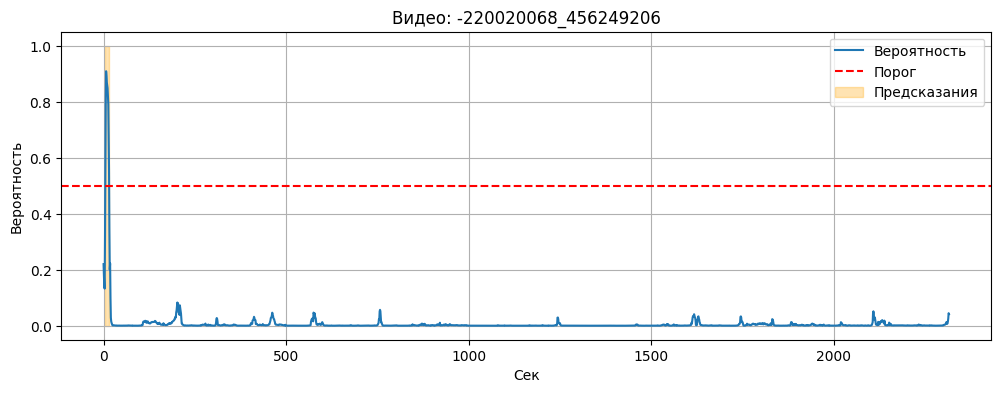

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(probs, label='Вероятность')
plt.axhline(0.5, color='red', linestyle='--', label='Порог')
plt.fill_between(range(len(probs)), 0, 1, where=pred_mask.astype(bool), color='orange', alpha=0.3, label='Предсказания')
plt.xlabel('Сек')
plt.ylabel('Вероятность')
plt.title(f'Видео: {video_id}')
plt.legend()
plt.grid()
plt.show()

In [93]:
def compute_iou(pred_start, pred_end, gt_start, gt_end):
    inter_start = max(pred_start, gt_start)
    inter_end = min(pred_end, gt_end)
    inter = max(0, inter_end - inter_start)

    union_start = min(pred_start, gt_start)
    union_end = max(pred_end, gt_end)
    union = union_end - union_start

    if union == 0:
        return 0.0
    return inter / union

def compute_metrics(pred_interval, gt_interval):
    ps, pe = pred_interval
    gs, ge = gt_interval

    iou = compute_iou(ps, pe, gs, ge)
    start_mae = abs(ps - gs)
    end_mae = abs(pe - ge)
    return iou, start_mae, end_mae

In [94]:
def get_main_interval_from_mask(mask, fps=1):
    intervals = mask_to_intervals(mask, fps)
    if not intervals:
        return None
    return max(intervals, key=lambda x: x[1] - x[0])

In [95]:
feats_dir = "/kaggle/input/serials/feats_test"
labels_dir = "/kaggle/input/serials/label_pt_test"
fps = 1

ious, start_maes, end_maes = [], [], []
n_total, n_skipped = 0, 0

for fname in tqdm(os.listdir(feats_dir)):
    if not fname.endswith("_feats.pt"):
        continue
    video_id = fname.replace("_feats.pt", "")
    feat_path = os.path.join(feats_dir, fname)
    label_path = os.path.join(labels_dir, f"{video_id}_labels.pt")

    if not os.path.exists(label_path):
        print(f"Skipping {video_id}, no label found")
        continue

    x = torch.load(feat_path)
    y = torch.load(label_path).float()

    min_len = min(x.shape[0], y.shape[0])
    x = x[:min_len]
    y = y[:min_len]

    feats = torch.load(feat_path).unsqueeze(0).to(device)
    probs, pred_mask = predict_on_video(model, feats, threshold=0.5)
    pred_mask = pred_mask[:min_len]

    pred_interval = get_main_interval_from_mask(pred_mask, fps)
    gt_interval = get_main_interval_from_mask(y.numpy().astype(int), fps)

    if pred_interval is None or gt_interval is None:
        n_skipped += 1
        continue

    iou, smae, emae = compute_metrics(pred_interval, gt_interval)
    ious.append(iou)
    start_maes.append(smae)
    end_maes.append(emae)
    n_total += 1

 16%|█▌        | 7/45 [00:00<00:01, 26.38it/s]

Skipping -220020068_456256475, no label found


 64%|██████▍   | 29/45 [00:01<00:00, 26.39it/s]

Skipping -220020068_456241671, no label found
Skipping -220020068_456241758, no label found


 82%|████████▏ | 37/45 [00:01<00:00, 31.86it/s]

Skipping -220020068_456257137, no label found
Skipping -220020068_456255346, no label found


100%|██████████| 45/45 [00:01<00:00, 26.54it/s]


In [96]:
print(f"\nEvaluated on {n_total} videos, skipped {n_skipped} due to empty predictions or labels.")
print(f"IoU: {np.mean(ious):.3f}")
print(f"Start MAE: {np.mean(start_maes):.2f} sec")
print(f"End MAE: {np.mean(end_maes):.2f} sec")


Evaluated on 40 videos, skipped 0 due to empty predictions or labels.
IoU: 0.799
Start MAE: 1.30 sec
End MAE: 1.38 sec


In [98]:
model_path = "zastavka_model.pt"

torch.save(model.state_dict(), model_path)

In [105]:
model = BiLSTMClassifier().to(device)

model.load_state_dict(torch.load("zastavka_model.pt"))
model.eval()

BiLSTMClassifier(
  (lstm): LSTM(768, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [126]:
def get_opening_interval(video_path, threshold=0.5):
    model = BiLSTMClassifier().to(device)
    model.load_state_dict(torch.load("zastavka_model.pt"))
    model.eval()
    feats = extract_dino_features(video_path).unsqueeze(0).to(device)
    _, pred_mask = predict_on_video(model, feats, threshold=0.5)
    return get_main_interval_from_mask(pred_mask)

def seconds_to_time(seconds):
    seconds = int(round(seconds))
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"{h}:{m:02}:{s:02}"

def print_opening_interval(video_path, threshold=0.5):
    start, end = get_opening_interval(video_path, threshold)
    return f"{seconds_to_time(start)} -- {seconds_to_time(end)}"

In [127]:
print_opening_interval("/kaggle/input/serials/data_test_short/data_test_short/-220020068_456249206/-220020068_456249206.mp4")

[NULL @ 0x2cded6c0] Invalid NAL unit size (1462 > 668).
[NULL @ 0x2cded6c0] missing picture in access unit with size 684
[h264 @ 0x2ced7880] Invalid NAL unit size (1462 > 668).
[h264 @ 0x2ced7880] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x198be140] stream 0, offset 0x12c0031a: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x198be140] stream 0, offset 0x12c008dd: partial file


'0:00:05 -- 0:00:15'